In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("player_injuries_impact.csv") 

df_info = df.info()
df_head = df.head()

df_info, df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Name                                656 non-null    object
 1   Team Name                           656 non-null    object
 2   Position                            656 non-null    object
 3   Age                                 656 non-null    int64 
 4   Season                              656 non-null    object
 5   FIFA rating                         656 non-null    int64 
 6   Injury                              656 non-null    object
 7   Date of Injury                      656 non-null    object
 8   Date of return                      656 non-null    object
 9   Match1_before_injury_Result         656 non-null    object
 10  Match1_before_injury_Opposition     656 non-null    object
 11  Match1_before_injury_GD             656 non-null    object

(None,
                Name  Team Name     Position  Age   Season  FIFA rating  \
 0  Jamaal Lascelles  Newcastle  Center Back   26  2019/20           77   
 1      Fabian Schär  Newcastle  Center Back   28  2019/20           79   
 2      Fabian Schär  Newcastle  Center Back   28  2019/20           79   
 3      Fabian Schär  Newcastle  Center Back   28  2019/20           79   
 4      Paul Dummett  Newcastle  Center Back   28  2019/20           75   
 
              Injury Date of Injury Date of return Match1_before_injury_Result  \
 0       Knee injury    Nov 9, 2019   Jan 13, 2020                        draw   
 1       Knee injury   Oct 20, 2019   Nov 24, 2019                        lose   
 2  Hamstring strain    Jan 2, 2020   Jan 17, 2020                        lose   
 3   Shoulder injury   Jul 16, 2020   Sep 28, 2020                        lose   
 4      Groin injury   Dec 22, 2019   Jan 10, 2020                         win   
 
    ... Match1_after_injury_GD Match1_after_inj

In [2]:
def clean_rating(value):
    try:
        if isinstance(value, str):
            value = value.strip().replace("N.A.", "").replace("(S)", "").replace("(s)", "")
            value = ''.join([c for c in value if c.isdigit() or c == '.'])
            return float(value) if value else np.nan
        return float(value)
    except:
        return np.nan

rating_cols = [
    'Match1_before_injury_Player_rating', 'Match2_before_injury_Player_rating', 'Match3_before_injury_Player_rating',
    'Match1_after_injury_Player_rating', 'Match2_after_injury_Player_rating', 'Match3_after_injury_Player_rating'
]

for col in rating_cols:
    df[col] = df[col].apply(clean_rating)

df['Avg_Pre_Rating'] = df[['Match1_before_injury_Player_rating', 'Match2_before_injury_Player_rating', 'Match3_before_injury_Player_rating']].mean(axis=1)
df['Avg_Post_Rating'] = df[['Match1_after_injury_Player_rating', 'Match2_after_injury_Player_rating', 'Match3_after_injury_Player_rating']].mean(axis=1)
df['Rating_Drop_%'] = ((df['Avg_Pre_Rating'] - df['Avg_Post_Rating']) / df['Avg_Pre_Rating']) * 100
df['Decline_Label'] = np.where(df['Rating_Drop_%'] > 0, 1, 0)


In [3]:
df['Date of Injury'] = pd.to_datetime(df['Date of Injury'], errors='coerce')
df['Date of return'] = pd.to_datetime(df['Date of return'], errors='coerce')
df['Injury_Duration'] = (df['Date of return'] - df['Date of Injury']).dt.days

# Select and clean features
features = ['Age', 'FIFA rating', 'Avg_Pre_Rating', 'Injury_Duration', 'Position', 'Injury', 'Decline_Label']
df_model = df[features].dropna()
df_model = df_model.rename(columns={'Injury': 'Injury_Type'})
df_model = pd.get_dummies(df_model, columns=['Position', 'Injury_Type'], drop_first=True)


In [4]:
X = df_model.drop(columns=['Decline_Label'])
y = df_model['Decline_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

voting_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('lr', lr_model)
], voting='soft')

voting_model.fit(X_train, y_train)

preds = voting_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("AUC Score:", roc_auc_score(y_test, preds))


C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:01:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:01:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7075471698113207
AUC Score: 0.6807971014492753


In [5]:
df

,Name,Team Name,Position,Age,Season,FIFA rating,Injury,Date of Injury,Date of return,Match1_before_injury_Result,...,Match2_after_injury_Player_rating,Match3_after_injury_Result,Match3_after_injury_Opposition,Match3_after_injury_GD,Match3_after_injury_Player_rating,Avg_Pre_Rating,Avg_Post_Rating,Rating_Drop_%,Decline_Label,Injury_Duration
0,Jamaal Lascelles,Newcastle,Center Back,26,2019/20,77,Knee injury,2019-11-09,2020-01-13,draw,...,6.2,draw,Norwich City,0,6.7,6.433333,6.666667,-3.626943,0,65.0
1,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Knee injury,2019-10-20,2019-11-24,lose,...,NaN,N.A.,N.A.,N.A.,NaN,6.466667,NaN,NaN,0,35.0
2,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Hamstring strain,2020-01-02,2020-01-17,lose,...,NaN,lose,Crystal Palace,-1,6.5,6.066667,6.250000,-3.021978,0,15.0
3,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Shoulder injury,2020-07-16,2020-09-28,lose,...,NaN,N.A.,N.A.,N.A.,NaN,5.933333,NaN,NaN,0,74.0
4,Paul Dummett,Newcastle,Center Back,28,2019/20,75,Groin injury,2019-12-22,2020-01-10,win,...,NaN,N.A.,N.A.,N.A.,NaN,6.000000,NaN,NaN,0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,James Garner,Everton,Defensive Midfielder,21,2022/23,72,back injury,2022-11-12,2023-02-09,lose,...,NaN,N.A.,N.A.,N.A.,NaN,6.166667,NaN,NaN,0,89.0
652,Dwight McNeil,Everton,Left winger,23,2023/24,76,ankle injury,NaT,2023-09-01,N.A.,...,5.4,win,Brentford,2,7.6,NaN,6.333333,NaN,0,NaN
653,Ashley Young,Everton,Left Back,38,2023/24,75,muscle injury,2023-12-11,2024-01-25,win,...,6.3,lose,Man City,-2,5.2,6.533333,5.700000,12.755102,1,45.0
654,Jack Harrison,Everton,Right winger,26,2023/24,76,hip injury,2023-07-01,2023-09-21,N.A.,...,8.5,lose,Liverpool,-2,5.4,NaN,6.800000,NaN,0,82.0


In [6]:
# Assuming you've already done:
# df_model = df[['Age', 'FIFA rating', 'Avg_Pre_Rating', 'Injury_Duration', 'Position', 'Injury', 'Decline_Label', 'Rating_Drop_%']].dropna()

df_model = df[['Age', 'FIFA rating', 'Avg_Pre_Rating', 'Injury_Duration', 'Position', 'Injury', 'Rating_Drop_%']].dropna()
df_model = df_model.rename(columns={'Injury': 'Injury_Type'})

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_model, columns=['Position', 'Injury_Type'], drop_first=True)


In [7]:
df

,Name,Team Name,Position,Age,Season,FIFA rating,Injury,Date of Injury,Date of return,Match1_before_injury_Result,...,Match2_after_injury_Player_rating,Match3_after_injury_Result,Match3_after_injury_Opposition,Match3_after_injury_GD,Match3_after_injury_Player_rating,Avg_Pre_Rating,Avg_Post_Rating,Rating_Drop_%,Decline_Label,Injury_Duration
0,Jamaal Lascelles,Newcastle,Center Back,26,2019/20,77,Knee injury,2019-11-09,2020-01-13,draw,...,6.2,draw,Norwich City,0,6.7,6.433333,6.666667,-3.626943,0,65.0
1,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Knee injury,2019-10-20,2019-11-24,lose,...,NaN,N.A.,N.A.,N.A.,NaN,6.466667,NaN,NaN,0,35.0
2,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Hamstring strain,2020-01-02,2020-01-17,lose,...,NaN,lose,Crystal Palace,-1,6.5,6.066667,6.250000,-3.021978,0,15.0
3,Fabian Schär,Newcastle,Center Back,28,2019/20,79,Shoulder injury,2020-07-16,2020-09-28,lose,...,NaN,N.A.,N.A.,N.A.,NaN,5.933333,NaN,NaN,0,74.0
4,Paul Dummett,Newcastle,Center Back,28,2019/20,75,Groin injury,2019-12-22,2020-01-10,win,...,NaN,N.A.,N.A.,N.A.,NaN,6.000000,NaN,NaN,0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,James Garner,Everton,Defensive Midfielder,21,2022/23,72,back injury,2022-11-12,2023-02-09,lose,...,NaN,N.A.,N.A.,N.A.,NaN,6.166667,NaN,NaN,0,89.0
652,Dwight McNeil,Everton,Left winger,23,2023/24,76,ankle injury,NaT,2023-09-01,N.A.,...,5.4,win,Brentford,2,7.6,NaN,6.333333,NaN,0,NaN
653,Ashley Young,Everton,Left Back,38,2023/24,75,muscle injury,2023-12-11,2024-01-25,win,...,6.3,lose,Man City,-2,5.2,6.533333,5.700000,12.755102,1,45.0
654,Jack Harrison,Everton,Right winger,26,2023/24,76,hip injury,2023-07-01,2023-09-21,N.A.,...,8.5,lose,Liverpool,-2,5.4,NaN,6.800000,NaN,0,82.0


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Set features and target
X_reg = df_encoded.drop(columns=['Rating_Drop_%'])
y_reg = df_encoded['Rating_Drop_%']

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train the regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predict
reg_preds = rf_reg.predict(X_test_reg)

# Evaluate
mae = mean_absolute_error(y_test_reg, reg_preds)
rmse = np.sqrt(mean_squared_error(y_test_reg, reg_preds))

print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))


MAE: 6.2123
RMSE: 8.0914


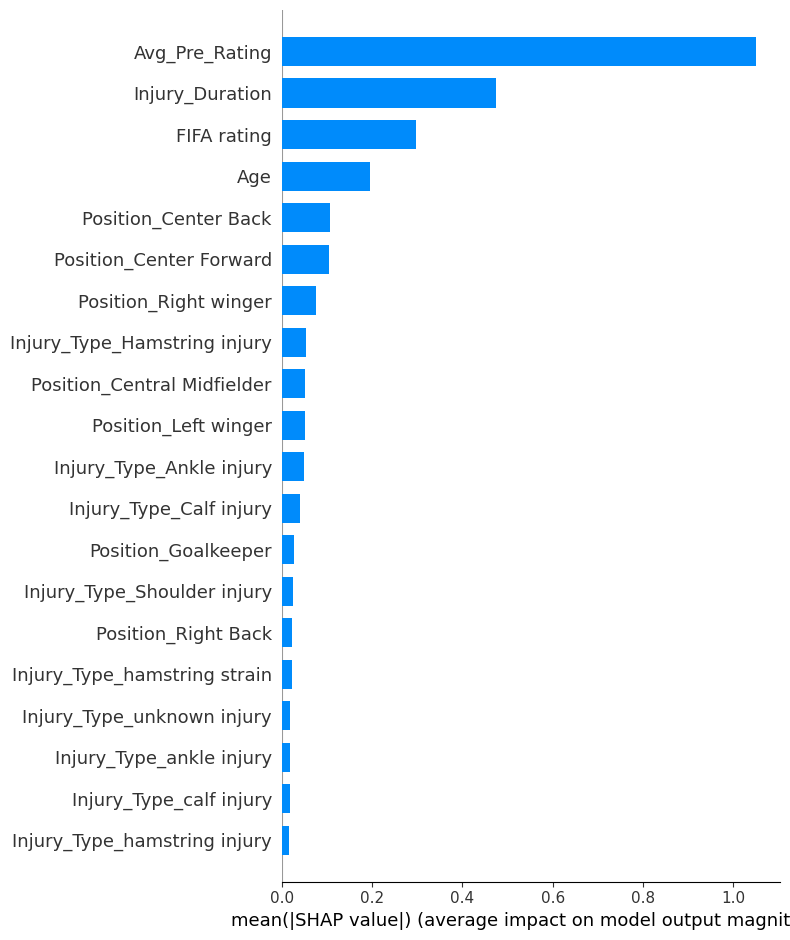

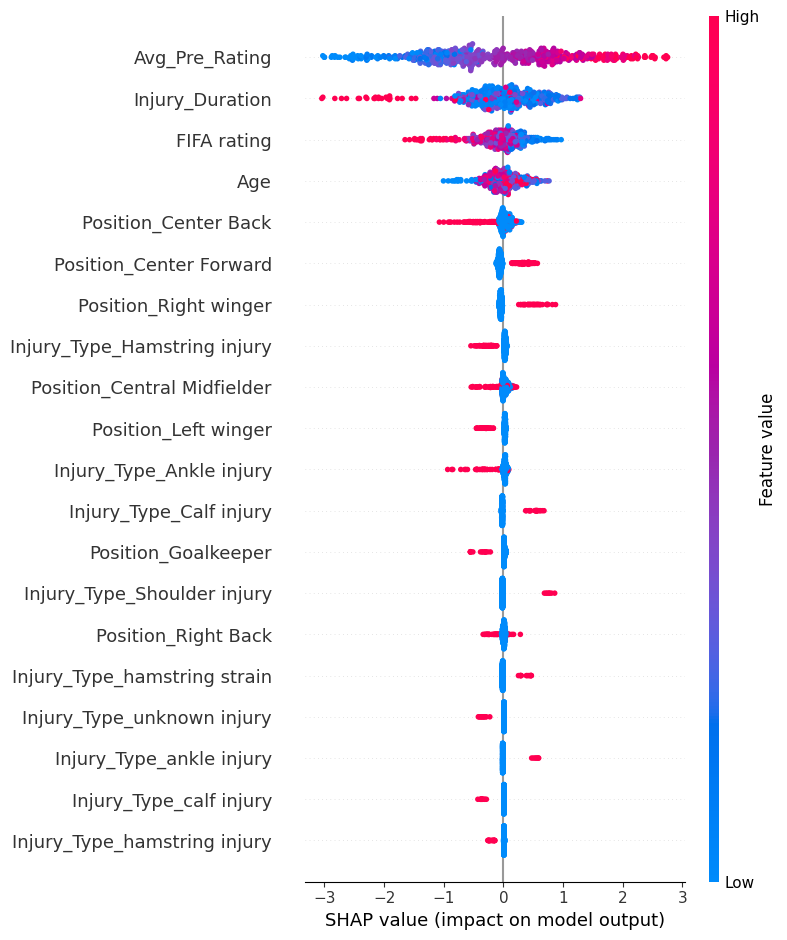

In [9]:
import shap
import matplotlib.pyplot as plt

# Create SHAP Explainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X)

# Summary Bar Plot
shap.summary_plot(shap_values, X, plot_type="bar")

# Full Summary Dot Plot
shap.summary_plot(shap_values, X)


In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Initialize and train model
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))
print("AUC Score:", round(auc, 4))
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


Accuracy: 0.7736
AUC Score: 0.8109
Confusion Matrix:
 [[56  4]
 [20 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82        60
           1       0.87      0.57      0.68        46

    accuracy                           0.77       106
   macro avg       0.80      0.75      0.75       106
weighted avg       0.79      0.77      0.76       106



In [13]:
# Standardization for SVM
from sklearn.preprocessing import StandardScaler
# Stacking Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import xgboost as xgb
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_preds = svm_model.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_preds)
svm_auc = roc_auc_score(y_test, svm_preds)



stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
        ('rf', RandomForestClassifier(random_state=42)),
        ('lr', LogisticRegression())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
stack_model.fit(X_train, y_train)
stack_preds = stack_model.predict(X_test)
stack_acc = accuracy_score(y_test, stack_preds)
stack_auc = roc_auc_score(y_test, stack_preds)

{
    "SVM": {"Accuracy": svm_acc, "AUC": svm_auc},
    "Stacking Ensemble": {"Accuracy": stack_acc, "AUC": stack_auc}
}

C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:03:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:03:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learne

{'SVM': {'Accuracy': 0.5943396226415094,
  'AUC': np.float64(0.5528985507246377)},
 'Stacking Ensemble': {'Accuracy': 0.7075471698113207,
  'AUC': np.float64(0.6757246376811593)}}

In [14]:
# Show previously computed SVM results
svm_results = {
    "SVM": {
        "Accuracy": svm_acc,
        "AUC": svm_auc
    }
}
svm_results


{'SVM': {'Accuracy': 0.5943396226415094,
  'AUC': np.float64(0.5528985507246377)}}

In [15]:
# Re-run Stacking model using simpler base learners and reduced folds to prevent timeout
from sklearn.model_selection import StratifiedKFold

stack_model_fast = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)),
        ('lr', LogisticRegression(max_iter=200))
    ],
    final_estimator=LogisticRegression(),
    cv=StratifiedKFold(n_splits=3)
)

stack_model_fast.fit(X_train, y_train)
stack_preds_fast = stack_model_fast.predict(X_test)
stack_acc_fast = accuracy_score(y_test, stack_preds_fast)
stack_auc_fast = roc_auc_score(y_test, stack_preds_fast)

{
    "Stacking Ensemble (Fast)": {
        "Accuracy": stack_acc_fast,
        "AUC": stack_auc_fast
    }
}


C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

{'Stacking Ensemble (Fast)': {'Accuracy': 0.7075471698113207,
  'AUC': np.float64(0.6731884057971015)}}

In [16]:
# Standardization for SVM
from sklearn.preprocessing import StandardScaler
# Stacking Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# SVM Classifier
svm_model = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)
svm_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

# Stacking Ensemble
base_learners = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42))
]
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_train, y_train)
stack_preds = stacking_model.predict(X_test)
stack_accuracy = accuracy_score(y_test, stack_preds)
stack_auc = roc_auc_score(y_test, stacking_model.predict_proba(X_test)[:, 1])

{
    "SVM Accuracy": round(svm_accuracy, 4),
    "SVM AUC": round(svm_auc, 4),
    "Stacking Accuracy": round(stack_accuracy, 4),
    "Stacking AUC": round(stack_auc, 4)
}

{'SVM Accuracy': 0.566,
 'SVM AUC': np.float64(0.8178),
 'Stacking Accuracy': 0.6887,
 'Stacking AUC': np.float64(0.7975)}

Accuracy: 0.7736
AUC Score: 0.8109

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82        60
           1       0.87      0.57      0.68        46

    accuracy                           0.77       106
   macro avg       0.80      0.75      0.75       106
weighted avg       0.79      0.77      0.76       106



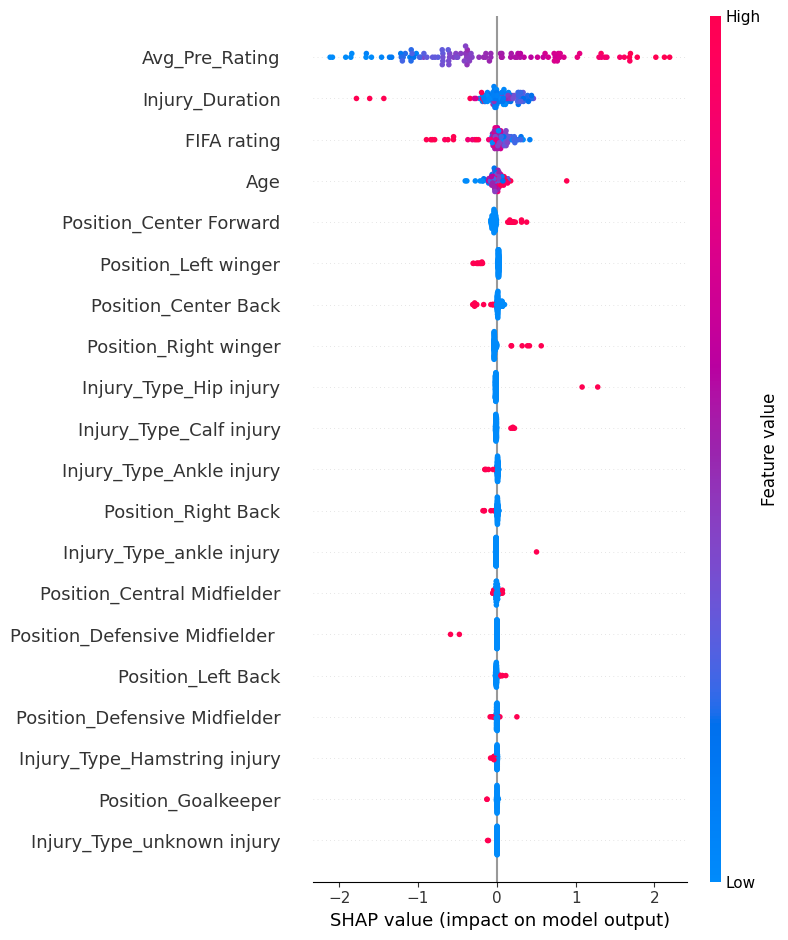

In [17]:
# Step 5: Train CatBoost
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)

# Step 6: Predictions & Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 7: SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP Summary
shap.summary_plot(shap_values, X_test)

In [20]:
pip install imblearn


   ---------------------------------------- 0/3 [sklearn-compat]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ---------------------------------------- 3/3 [imblearn]

Note: you may need to restart the kernel to use updated packages.


📊 Evaluation Summary
----------------------------------------
🔍 Accuracy            : 0.7736
🔍 Precision (avg)     : 0.8018
🔍 Recall (avg)        : 0.7493
🔍 F1 Score (avg)      : 0.7539
🔍 Balanced Accuracy   : 0.7493
🧠 MCC                 : 0.5485
🤝 Cohen's Kappa       : 0.5196
📐 G-Mean              : 0.7263
📉 MAE                 : 0.2264
📉 RMSE                : 0.4758


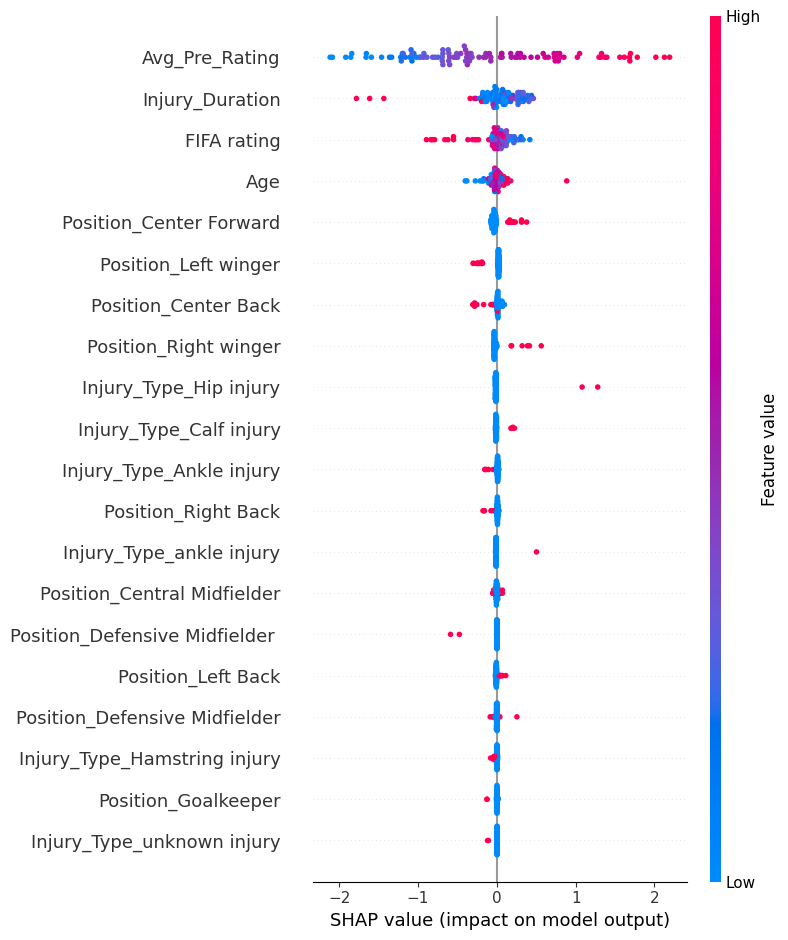

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
)
from catboost import CatBoostClassifier
import shap
import matplotlib.pyplot as plt
from imblearn.metrics import geometric_mean_score

# Step 6: Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Step 7: Print Evaluation Summary
print("📊 Evaluation Summary")
print("----------------------------------------")
print(f"🔍 Accuracy            : {accuracy:.4f}")
print(f"🔍 Precision (avg)     : {precision:.4f}")
print(f"🔍 Recall (avg)        : {recall:.4f}")
print(f"🔍 F1 Score (avg)      : {f1:.4f}")
print(f"🔍 Balanced Accuracy   : {balanced_acc:.4f}")
print(f"🧠 MCC                 : {mcc:.4f}")
print(f"🤝 Cohen's Kappa       : {kappa:.4f}")
print(f"📐 G-Mean              : {gmean:.4f}")
print(f"📉 MAE                 : {mae:.4f}")
print(f"📉 RMSE                : {rmse:.4f}")

# Step 8: SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Optional: Enable SHAP plots in Jupyter
shap.initjs()

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

In [32]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# Clean and convert match ratings to numeric
cols_pre = ['Match1_before_injury_Player_rating', 'Match2_before_injury_Player_rating', 'Match3_before_injury_Player_rating']
cols_post = ['Match1_after_injury_Player_rating', 'Match2_after_injury_Player_rating', 'Match3_after_injury_Player_rating']

# Clean and convert values to float (remove non-numeric garbage)
for col in cols_pre + cols_post:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing rating values
df.dropna(subset=cols_pre + cols_post, inplace=True)

# Compute average pre and post ratings
df['pre_avg'] = df[cols_pre].mean(axis=1)
df['post_avg'] = df[cols_post].mean(axis=1)

# Paired t-test (assumes normality)
t_stat, p_ttest = ttest_rel(df['pre_avg'], df['post_avg'])

# Wilcoxon signed-rank test (non-parametric)
w_stat, p_wilcoxon = wilcoxon(df['pre_avg'], df['post_avg'])

# Show results
print("📊 Paired t-test:")
print(f"T-statistic = {t_stat:.4f}, p-value = {p_ttest:.4f}")

print("\n📊 Wilcoxon signed-rank test:")
print(f"Wilcoxon statistic = {w_stat:.4f}, p-value = {p_wilcoxon:.4f}")

# Interpretation
if p_ttest < 0.05 or p_wilcoxon < 0.05:
    print("\n✅ Significant difference between pre- and post-injury performance.")
else:
    print("\n❌ No statistically significant difference found.")


📊 Paired t-test:
T-statistic = -0.2701, p-value = 0.7873

📊 Wilcoxon signed-rank test:
Wilcoxon statistic = 21564.0000, p-value = 0.8560

❌ No statistically significant difference found.


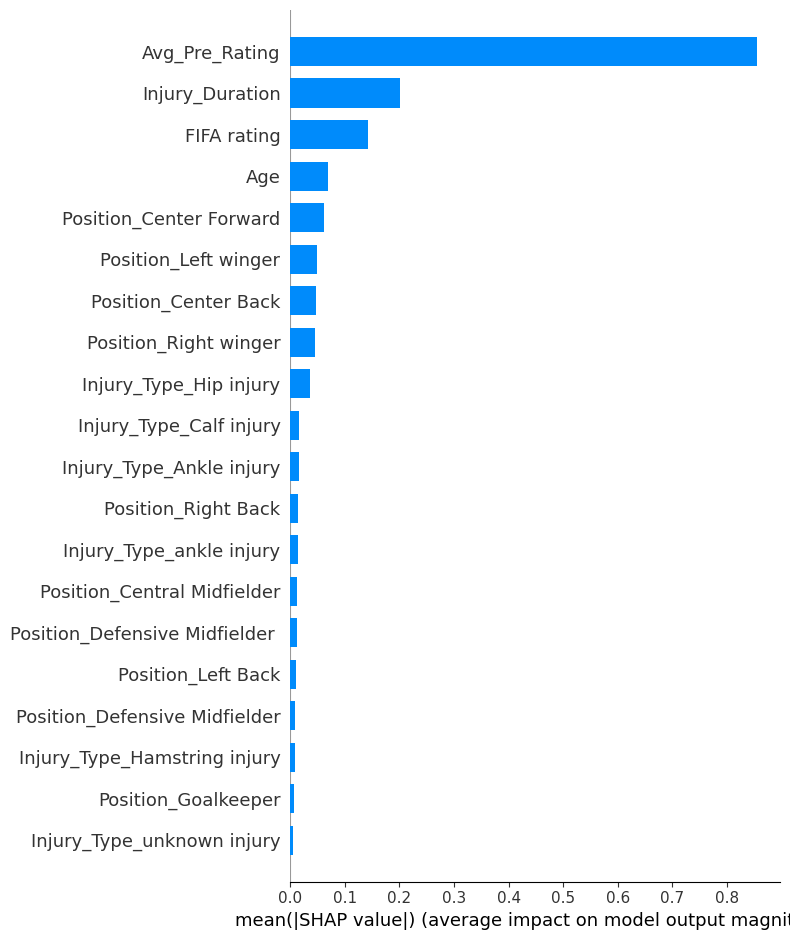

In [22]:
shap.summary_plot(shap_values, X, plot_type="bar")

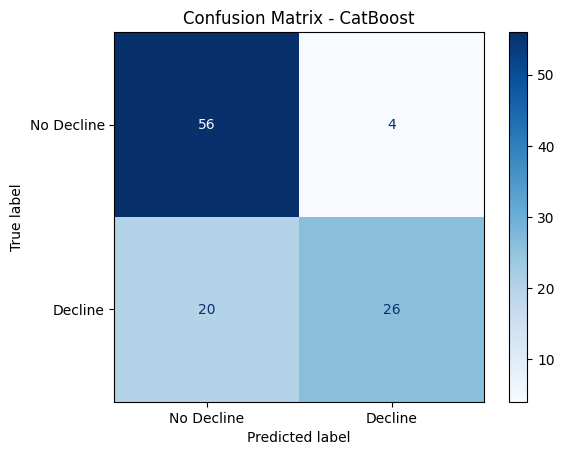

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Decline", "Decline"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - CatBoost')
plt.grid(False)
plt.show()

In [31]:
# Remove columns with unsupported types (like boolean or object)
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

# Drop any non-numeric columns just to be safe
X_train_lgb = X_train_lgb.select_dtypes(include=['number'])
X_test_lgb = X_test_lgb.select_dtypes(include=['number'])

# Drop any rows with NaN or Inf
X_train_lgb = X_train_lgb.replace([np.inf, -np.inf], np.nan).dropna()
X_test_lgb = X_test_lgb.replace([np.inf, -np.inf], np.nan).dropna()

# Match target labels accordingly
y_train_lgb = y_train[X_train_lgb.index]
y_test_lgb = y_test[X_test_lgb.index]

from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_lgb, y_train_lgb)

lgb_preds = lgb_model.predict(X_test_lgb)
lgb_probs = lgb_model.predict_proba(X_test_lgb)[:, 1]

print("LightGBM Accuracy:", accuracy_score(y_test_lgb, lgb_preds))
print("LightGBM AUC Score:", roc_auc_score(y_test_lgb, lgb_probs))



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 170, number of negative: 254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400943 -> initscore=-0.401536
[LightGBM] [Info] Start training from score -0.401536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [26]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [28]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))
print("Logistic Regression AUC Score:", roc_auc_score(y_test, log_probs))


Logistic Regression Accuracy: 0.7264150943396226
Logistic Regression AUC Score: 0.7952898550724637


In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("Random Forest AUC Score:", roc_auc_score(y_test, rf_probs))


Random Forest Accuracy: 0.6981132075471698
Random Forest AUC Score: 0.7706521739130435


In [30]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("XGBoost AUC Score:", roc_auc_score(y_test, xgb_probs))


C:\Users\h\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:38:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.6509433962264151
XGBoost AUC Score: 0.7101449275362318
